In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os

In [21]:
#Variables definition
Omega_r = None #Rotor rotational speed
Omega_g = None #Generator rotational speed
dOmega_r = None #Rotor rotational acceleration
dOmega_g = None #Generator rotational acceleration
Theta = None #Torsional displacement
dTheta = None #Torsional speed
Rho_v = 1.225 #Air density
v_t = None #Wind speed
v_bar = 10 #Average wind
vTil_L = 5 #Minimum wind turbulence intensity
vTil_U = 0.2 #Maximum wind turbulence intensity
R_r = 57.5 #Rotor radius
A_r = None #Rotor area
Rho_r = None #XXXXX
B_dt = 755.49 #Damping of the drivetrain
K_dt = 2.7*(1e9) #Stiness of the drivetrain
J_r = 55*(1e6) #Inertia of the rotor
J_g = 55*(1e6) #Inertia of the drivetrain
C_pMax = 0.486 #Max. power coefficient
Lambda_opt = 7.6 #Optimal tip-speed ratio
Phi_opt = 0 #Optimal pitch angle 0 deg

In [22]:
#Matrices definition

A=np.array([[-B_dt/J_r, B_dt/J_r, -K_dt/J_r],
            [B_dt/J_r, -B_dt/J_r, K_dt/J_r],
            [1, -1, 0]])

B = np.array([[1/J_r, 0],
              [0, -1/J_g],
              [0, 0]])

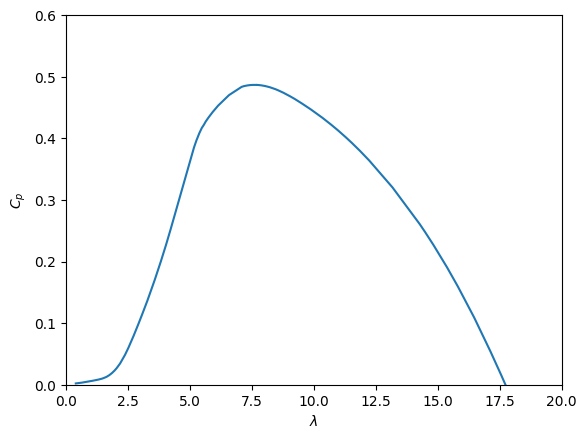

In [18]:
path = '/home/claudio/Documentos/PythonProjects/ControleRobusto/CpVersusTSR&Pitch_WT_Perf_V1.csv'
df = pd.read_csv(path,header=None)
x = df.iloc[:,0].values
y = df.iloc[:,6].values
y_max = np.max(y)
x_max=np.where(y==y_max)
plt.plot(x,y)

plt.xlim(0, 20)
plt.ylim(0, 0.6)
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$C_p$')
plt.show()

5.1.1 | Aerodynamics Model

In [ ]:
def Lambda_t(Omega_r,R_r,v_t):
    return Omega_r*R_r/v_t

def Cp_t(C_pMax,Lambda_opt,Lambda):
    return C_pMax*(Lambda**3)/(Lambda_opt**3)

def tau_r_t(Rho_v, A_r, Cp, v_t, Omega_r):
    return 0.5*Rho_v*A_r*Cp*(v_t**3)/Omega_r

Executando simulações SEM o controlador RUL...


100%|██████████| 50/50 [00:03<00:00, 14.39it/s]


Executando simulações COM o controlador RUL...


  0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_47281/842000925.py:31: RuntimeWarning: overflow encountered in scalar multiply
  cp = c1 * (c2 / li - c4) * np.exp(-c5 / li) + c6 * lamb
 24%|██▍       | 12/50 [00:00<00:02, 14.33it/s]/tmp/ipykernel_47281/842000925.py:31: RuntimeWarning: overflow encountered in exp
  cp = c1 * (c2 / li - c4) * np.exp(-c5 / li) + c6 * lamb
100%|██████████| 50/50 [00:03<00:00, 14.37it/s]



--- Resultados Compilados ---
            eol_h      total_energy_MWh     
             mean  std             mean  std
scenario                                    
With RUL      0.0  0.0         0.000083  0.0
Without RUL   0.0  0.0         0.000133  0.0


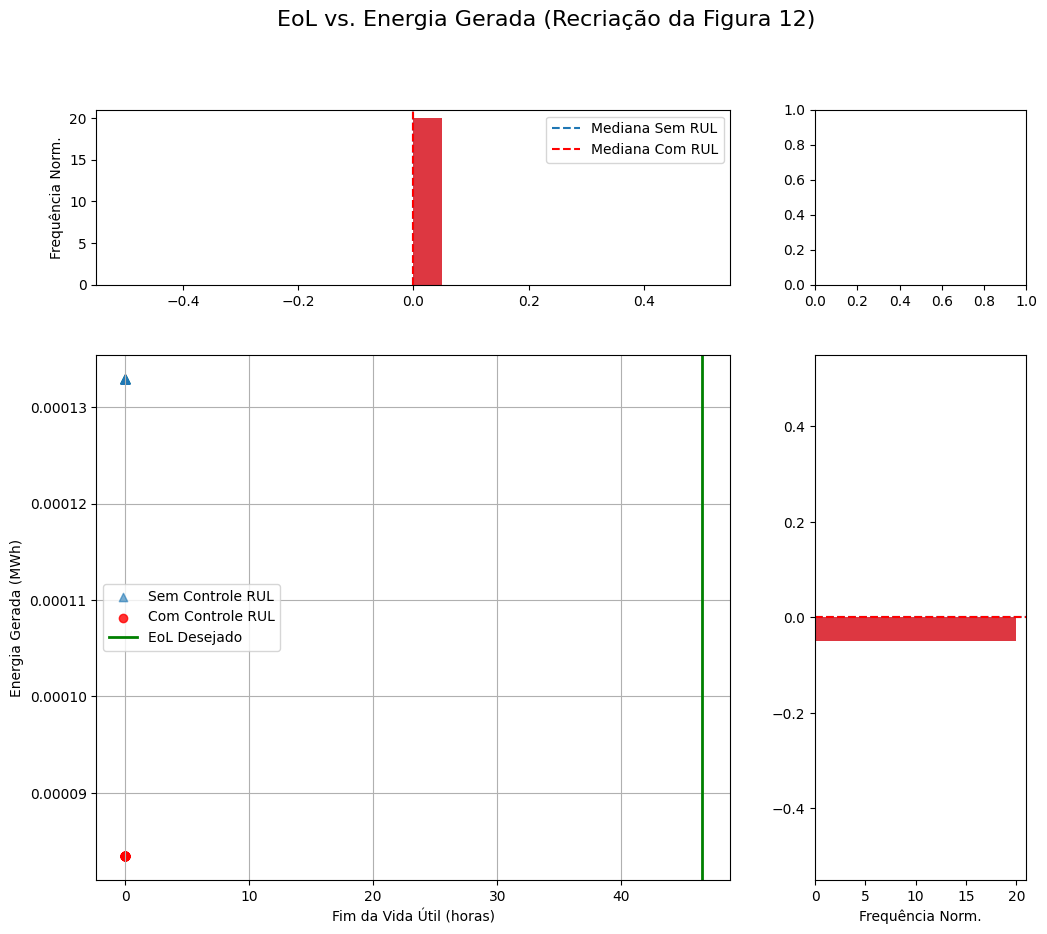

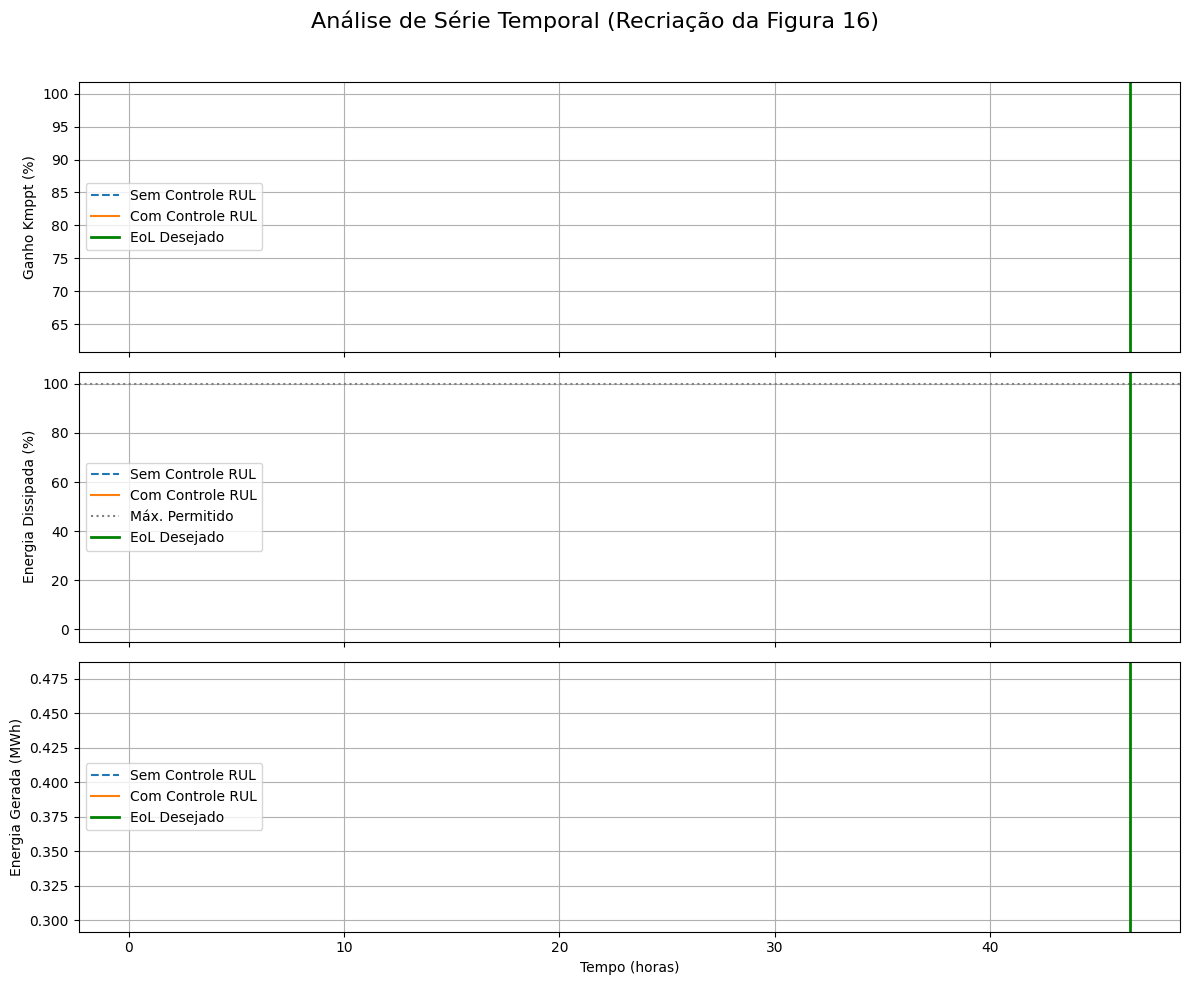

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# =============================================================================
# STEP 1: MODELO DA TURBINA EÓLICA (HAWT)
# Baseado na Seção 5.1 do artigo
# =============================================================================
class HAWTModel:
    def __init__(self, params):
        self.params = params
        # Estados iniciais do drivetrain [velocidade angular do rotor, velocidade angular do gerador, ângulo de torção]
        self.states = np.array([1.5, 1.5, 0.0]) # Valores iniciais razoáveis
        self.total_dissipated_energy = 0.0
        self.total_generated_energy = 0.0

    def _get_cp(self, lamb, phi):
        # Esta é uma aproximação da curva Cp da Figura 1 para phi=0.
        # Uma implementação mais precisa usaria uma tabela de busca 2D.
        c1 = 0.5176
        c2 = 116
        c3 = 0.4
        c4 = 5
        c5 = 21
        c6 = 0.0068
        c7 = -0.08
        c8 = 0.035

        li = 1 / (lamb + c7 * phi) - c8 / (phi**3 + 1)
        cp = c1 * (c2 / li - c4) * np.exp(-c5 / li) + c6 * lamb
        return max(0, cp)

    def step(self, v_wind, lambda_star, dt):
        wr, wg, theta_ts = self.states

        # Etapa 1: Calcular lambda atual (Equação 3)
        lamb = (wr * self.params['Rr']) / v_wind if v_wind > 0 else 0

        # Etapa 2: Obter Cp
        cp = self._get_cp(lamb, self.params['phi_opt'])

        # Etapa 3: Calcular torque aerodinâmico (Equação 64)
        tau_r = 0.5 * self.params['rho'] * self.params['Ar'] * (v_wind**3) * cp / wr if wr > 0 else 0

        # Etapa 4: Implementar o controlador GTC padrão
        # O ganho Kmppt é ajustado pelo lambda_star (Equação 732)
        cp_star = self._get_cp(lambda_star, self.params['phi_opt'])
        k_mppt = 0.5 * self.params['rho'] * self.params['Ar'] * self.params['Rr']**3 * cp_star / (lambda_star**3)
        # O torque do gerador é calculado (Equação 4)
        tau_g = k_mppt * wg**2

        # Resolver a dinâmica do drivetrain (Equação 65) usando o método de Euler
        Kdt = self.params['Kdt']
        Bdt = self.params['Bdt']
        Jr = self.params['Jr']
        Jg = self.params['Jg']

        wr_dot = (tau_r - Kdt * theta_ts - Bdt * (wr - wg)) / Jr
        wg_dot = (Kdt * theta_ts + Bdt * (wr - wg) - tau_g) / Jg
        theta_ts_dot = wr - wg

        self.states += np.array([wr_dot, wg_dot, theta_ts_dot]) * dt
        
        # Etapa 5: Calcular a degradação e a energia gerada
        # Potência dissipada (Equação 66)
        dissipated_power = Bdt * (self.states[0] - self.states[1])**2
        self.total_dissipated_energy += dissipated_power * dt # (Equação 67)

        # Potência gerada (Equação 69)
        generated_power = tau_g * self.states[1]
        self.total_generated_energy += generated_power * dt
        
        return self.total_dissipated_energy, self.total_generated_energy, k_mppt

# =============================================================================
# STEP 2: IMPLEMENTAÇÃO DO CONTROLADOR RUL
# Baseado nas Seções 4.2, 4.3 e 5.2
# =============================================================================
class RULController:
    def __init__(self, params):
        self.params = params
        # Estados do controlador: [u_{k-1}, z_k]
        self.u_k_minus_1 = 0.0
        self.z_k = 0.0
        # Estados do observador: [D_hat, beta_hat]
        self.observer_states = np.array([0.0, 0.0])
        # Ganhos do observador (requer solução LMI, usando valores razoáveis para demonstração)
        self.L = np.array([0.1, 0.01]) 
        # Ganhos do controlador pré-calculados do artigo
        self.K1 = 0.4150
        self.K2 = 0.0093

    def step(self, current_dissipated_energy, k, dt):
        # --- Observador de Estado (Seção 5.2.1) ---
        D_hat_prev, beta_hat_prev = self.observer_states
        y_k = current_dissipated_energy
        
        # Equação do observador (Equação 70 com matrizes da Equação 71)
        # H = [[1, dt], [0, 1]]
        H = np.array([[1, dt],[0, 1]])
        C = np.array([1, 0])

        x_hat_posteriori = H @ self.observer_states
        self.observer_states = x_hat_posteriori + self.L * (y_k - C @ x_hat_posteriori)
        
        D_hat = self.observer_states[0]
        beta_hat = self.observer_states[1]

        # --- Conversor de Referência (Seção 5.2.2) ---
        t_f_ref = self.params['t_f_ref']
        D_max = self.params['D_max']
        
        rul_ref = t_f_ref - (k * dt)
        if rul_ref <= 0:
            rul_ref = dt # Evitar divisão por zero

        # Calcular beta_ref (Equação 75)
        beta_ref = (D_max - D_hat) / rul_ref

        # --- Controlador de Feedback (Seção 5.2.4) ---
        # Atualizar erro integral (Equação 84)
        self.z_k += (beta_hat - beta_ref) * dt
        
        # Calcular ação de controle u_k (Equação 83)
        u_k = -self.K1 * self.u_k_minus_1 - self.K2 * self.z_k
        
        # Atualizar u_{k-1} para a próxima iteração
        self.u_k_minus_1 = u_k
        
        # Calcular novo lambda_star (Equação 82)
        lambda_star = self.params['lambda_opt'] + u_k
        
        # Limitar lambda_star a valores razoáveis
        lambda_star = np.clip(lambda_star, 4, 10)
        
        return lambda_star

# =============================================================================
# STEP 3: LOOP DE SIMULAÇÃO PRINCIPAL
# =============================================================================
def generate_wind_speed(t_total, dt):
    time = np.arange(0, t_total, dt)
    # Gera uma velocidade do vento com flutuações, similar à Figura 15
    base_wind = 10.0
    turbulence = np.random.normal(0, 0.5, len(time))
    # Adiciona algumas mudanças de regime
    for i in range(len(time)):
        if time[i] > t_total * 0.2:
            base_wind = 8.0
        if time[i] > t_total * 0.5:
            base_wind = 12.0
        if time[i] > t_total * 0.8:
            base_wind = 9.0
    return base_wind + np.cumsum(turbulence) * np.sqrt(dt)

def run_simulation(params, use_rul_controller=False):
    hawt = HAWTModel(params)
    if use_rul_controller:
        rul_controller = RULController(params)

    # Tempos de amostragem
    dt_inner = params['Ts_inner']
    dt_outer = params['Ts_outer']
    outer_steps_ratio = int(dt_outer / dt_inner)
    
    # Gerar vento
    t_sim_max = params['t_f_ref'] * 2 # Simular por tempo suficiente
    wind_speed = generate_wind_speed(t_sim_max, dt_inner)
    
    history = []
    lambda_star = params['lambda_opt']
    
    for k in range(len(wind_speed)):
        # O controlador RUL opera em uma taxa de amostragem mais lenta
        if use_rul_controller and k % outer_steps_ratio == 0:
            lambda_star = rul_controller.step(hawt.total_dissipated_energy, k, dt_outer)
            
        energy_d, energy_g, k_mppt = hawt.step(wind_speed[k], lambda_star, dt_inner)
        
        if k % outer_steps_ratio == 0: # Log na taxa mais lenta
            history.append({
                'time': k * dt_inner,
                'dissipated_energy': energy_d,
                'generated_energy': energy_g,
                'k_mppt_gain': k_mppt,
                'lambda_star': lambda_star
            })

        if energy_d >= params['D_max']:
            break # Fim da vida útil atingido
            
    return pd.DataFrame(history)

# =============================================================================
# STEP 4: ANÁLISE E VISUALIZAÇÃO
# =============================================================================
def analyze_and_visualize(all_results):
    # --- Recriar Figura 12 ---
    fig1, axs1 = plt.subplots(2, 2, figsize=(12, 10), gridspec_kw={'width_ratios': [3, 1], 'height_ratios': [1, 3]})
    fig1.suptitle('EoL vs. Energia Gerada (Recriação da Figura 12)', fontsize=16)
    
    ax_scatter = axs1[1, 0]
    ax_hist_x = axs1[0, 0]
    ax_hist_y = axs1[1, 1]

    # Dados
    without_rul = all_results[all_results['scenario'] == 'Without RUL']
    with_rul = all_results[all_results['scenario'] == 'With RUL']
    
    # Scatter plot
    ax_scatter.scatter(without_rul['eol_h'], without_rul['total_energy_MWh'], alpha=0.6, label='Sem Controle RUL', marker='^')
    ax_scatter.scatter(with_rul['eol_h'], with_rul['total_energy_MWh'], alpha=0.8, label='Com Controle RUL', color='red')
    ax_scatter.axvline(params['t_f_ref']/3600, color='green', linestyle='-', linewidth=2, label='EoL Desejado')
    ax_scatter.set_xlabel('Fim da Vida Útil (horas)')
    ax_scatter.set_ylabel('Energia Gerada (MWh)')
    ax_scatter.legend()
    ax_scatter.grid(True)
    
    # Histogramas
    ax_hist_x.hist(without_rul['eol_h'], bins=20, alpha=0.5, density=True)
    ax_hist_x.hist(with_rul['eol_h'], bins=20, alpha=0.7, color='red', density=True)
    ax_hist_x.axvline(without_rul['eol_h'].median(), linestyle='--', label='Mediana Sem RUL')
    ax_hist_x.axvline(with_rul['eol_h'].median(), linestyle='--', color='red', label='Mediana Com RUL')
    ax_hist_x.set_ylabel('Frequência Norm.')
    ax_hist_x.legend()
    
    ax_hist_y.hist(without_rul['total_energy_MWh'], bins=20, orientation='horizontal', alpha=0.5, density=True)
    ax_hist_y.hist(with_rul['total_energy_MWh'], bins=20, orientation='horizontal', alpha=0.7, color='red', density=True)
    ax_hist_y.axhline(without_rul['total_energy_MWh'].median(), linestyle='--')
    ax_hist_y.axhline(with_rul['total_energy_MWh'].median(), linestyle='--', color='red')
    ax_hist_y.set_xlabel('Frequência Norm.')

    # --- Recriar Figura 16 ---
    fig2, axs2 = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    fig2.suptitle('Análise de Série Temporal (Recriação da Figura 16)', fontsize=16)
    
    # Usar o último resultado da simulação para plotar
    df_no_rul = without_rul.iloc[-1]['history']
    df_with_rul = with_rul.iloc[-1]['history']
    
    # (a) Ganho Kmppt
    axs2[0].plot(df_no_rul['time']/3600, (df_no_rul['k_mppt_gain']/df_no_rul['k_mppt_gain'].iloc[0])*100, label='Sem Controle RUL', linestyle='--')
    axs2[0].plot(df_with_rul['time']/3600, (df_with_rul['k_mppt_gain']/df_no_rul['k_mppt_gain'].iloc[0])*100, label='Com Controle RUL')
    axs2[0].axvline(params['t_f_ref']/3600, color='green', linestyle='-', linewidth=2, label='EoL Desejado')
    axs2[0].set_ylabel('Ganho Kmppt (%)')
    axs2[0].legend()
    axs2[0].grid(True)

    # (b) Energia Dissipada
    axs2[1].plot(df_no_rul['time']/3600, (df_no_rul['dissipated_energy']/params['D_max'])*100, label='Sem Controle RUL', linestyle='--')
    axs2[1].plot(df_with_rul['time']/3600, (df_with_rul['dissipated_energy']/params['D_max'])*100, label='Com Controle RUL')
    axs2[1].axhline(100, color='gray', linestyle=':', label='Máx. Permitido')
    axs2[1].axvline(params['t_f_ref']/3600, color='green', linestyle='-', linewidth=2, label='EoL Desejado')
    axs2[1].set_ylabel('Energia Dissipada (%)')
    axs2[1].legend()
    axs2[1].grid(True)
    
    # (c) Energia Gerada
    axs2[2].plot(df_no_rul['time']/3600, df_no_rul['generated_energy']/1e6, label='Sem Controle RUL', linestyle='--')
    axs2[2].plot(df_with_rul['time']/3600, df_with_rul['generated_energy']/1e6, label='Com Controle RUL')
    axs2[2].axvline(params['t_f_ref']/3600, color='green', linestyle='-', linewidth=2, label='EoL Desejado')
    axs2[2].set_xlabel('Tempo (horas)')
    axs2[2].set_ylabel('Energia Gerada (MWh)')
    axs2[2].legend()
    axs2[2].grid(True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# =============================================================================
# EXECUTAR O SCRIPT
# =============================================================================
if __name__ == '__main__':
    # Parâmetros da simulação (Tabelas 1 e 2)
    params = {
        'rho': 1.225, 'Rr': 57.5, 'Ar': np.pi * 57.5**2,
        'Kdt': 2.7e9, 'Bdt': 755.49, 'Jr': 55e6, 'Jg': 55e6, # Jg do artigo parece um erro de digitação, usando o mesmo que Jr
        'lambda_opt': 7.6, 'phi_opt': 0,
        'D_max': 1000 * 3600, # Ws (J) - Aumentado para uma simulação mais longa
        't_f_ref': 46.49 * 3600, # segundos
        'Ts_inner': 1.0, # s
        'Ts_outer': 10.0, # s
    }

    NUM_SIMULATIONS = 50 # Artigo usa 200, reduzido para uma execução mais rápida
    all_results = []
    
    print("Executando simulações SEM o controlador RUL...")
    for i in tqdm(range(NUM_SIMULATIONS)):
        history = run_simulation(params, use_rul_controller=False)
        all_results.append({
            'scenario': 'Without RUL',
            'eol_h': history['time'].iloc[-1] / 3600,
            'total_energy_MWh': history['generated_energy'].iloc[-1] / (3600 * 1e6),
            'history': history
        })

    print("Executando simulações COM o controlador RUL...")
    for i in tqdm(range(NUM_SIMULATIONS)):
        history = run_simulation(params, use_rul_controller=True)
        all_results.append({
            'scenario': 'With RUL',
            'eol_h': history['time'].iloc[-1] / 3600,
            'total_energy_MWh': history['generated_energy'].iloc[-1] / (3600 * 1e6),
            'history': history
        })
        
    results_df = pd.DataFrame(all_results)
    
    print("\n--- Resultados Compilados ---")
    print(results_df.groupby('scenario')[['eol_h', 'total_energy_MWh']].agg(['mean', 'std']))

    analyze_and_visualize(results_df)